In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx   = 201
ny   = 201
xmin = 0.; xmax = 40.0
ymin = 0.; ymax = 40.0
radius = 2.5
T    = 2.0
CFL  = 0.99
g    = 9.81
mu   = xmax/2
sigma= 1.
dx   = (xmax-xmin) / (nx-1)
dy   = (ymax-ymin) / (ny-1)
dt   = 0.05
print("dx: ",dx," dy: ",dy," dt: ",dt)

dx:  0.2  dy:  0.2  dt:  0.05


In [3]:
def dtCourant(dx,dy,maxeigenu,maxeigenv,time,TMAX,CFL):
    dt  = CFL/(maxeigenu/dx + maxeigenv/dy)
    #if (dt < 1.e-12):
    #    dt = 1.e-12
    #if time+dt>TMAX:
    #    dt = TMAX-time
    return dt

def addGhostCells2D(var,gleft,gright,gbottom,gtop):
    var = np.vstack([gtop*np.ones(ny).reshape(1,ny),var,gbottom*np.ones(ny).reshape(1,ny)])
    var = np.hstack([gleft*np.ones(nx+2).reshape(nx+2,1),var,gright*np.ones(nx+2).reshape(nx+2,1)])
    return var

def bcNeumann2D(var):
    ### NEUMANN BC ###
    var[0,:]  = var[1,:]
    var[-1,:] = var[-2,:]
    var[:,0]  = var[:,1]
    var[:,-1] = var[:,-2]
    return var

def bcPeriodic2D(var):
    ### PERIODIC BC ###
    var[0,:]  = var[-2,:]
    var[-1,:] = var[1,:]
    var[:,0]  = var[:,-2]
    var[:,-1] = var[:,1]
    return var

----
## Two-sided Ritter dam break

$x$-direction

100 100 19.8


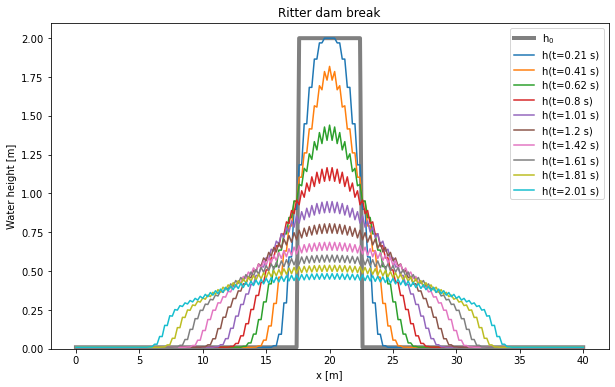

In [4]:
# Finite volume with Rusanov flux scheme
# start time
time   = 0
dtplot = 0.20
tplot  = dtplot
# initialisation
x   = np.linspace(xmin,xmax,nx)
y   = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y,indexing='ij')
h   = 0*X
#h   = np.exp(-((X-mu)**2+(Y-mu)**2)/sigma**2)
#h   = np.where(X <= xmax/2, 2., 0.01)
h   = np.where(np.sqrt((X-mu)**2)<= radius,2.,0.01)
hu  = 0*X
hv  = 0*X
# add ghost cells
X  = addGhostCells2D(X,xmin,xmax,ymin,ymax)
Y  = addGhostCells2D(Y,xmin,xmax,ymin,ymax)
h  = addGhostCells2D(h,0,0,0,0)
hu = addGhostCells2D(hu,0,0,0,0)
hv = addGhostCells2D(hv,0,0,0,0)
# initial plot
YM = Y[int(ny/2),int(ny/2)]
print(int(ny/2),int(ny/2),YM)
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('x [m]')
plt.ylabel('Water height [m]')
plt.title('Ritter dam break')
#plt.contour(X[1:-1,1:-1],Y[1:-1,1:-1],h[1:-1,1:-1],levels=[0.5,0.8,1.5])
plt.plot(X[1:-1,1:-1][Y[1:-1,1:-1]==YM],
         h[1:-1,1:-1][Y[1:-1,1:-1]==YM],linewidth=4,color='gray',label='h$_0$')
# solution
while (time < T):
    # set boundary conditions
    h  = bcNeumann2D(h)
    hu = bcNeumann2D(hu)
    hv = bcNeumann2D(hv)
    
    h = np.maximum(0.01,h)
    c = np.sqrt(g*h)
    u = hu/h #uu*h/h
    v = hv/h #vv*h/h
    
    maxeigenu = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    maxeigenv = np.max(np.maximum(np.abs(v-c),np.abs(v+c)))
    maxeigen = max(maxeigenu,maxeigenv)
    dt = dtCourant(dx,dy,maxeigenu,maxeigenv,time,T,CFL)
    #print('dt: ',dx,dt,time,maxeigen)
    # advance time
    time  = time+dt
    
    Fhup = h[1:,:]*u[1:,:]
    Fhum = h[:-1,:]*u[:-1,:]
    Fhvp = h[:,1:]*v[:,1:]
    Fhvm = h[:,:-1]*v[:,:-1]
    
    Fhu2p = h[1:,:]*u[1:,:]**2 + g*h[1:,:]**2/2
    Fhu2m = h[:-1,:]*u[:-1,:]**2 + g*h[:-1,:]**2/2
    Fhuvp = h[:,1:]*u[:,1:]*v[:,1:]
    Fhuvm = h[:,:-1]*u[:,:-1]*v[:,:-1]
    
    Fhuv2p = h[1:,:]*u[1:,:]*v[1:,:]
    Fhuv2m = h[:-1,:]*u[:-1,:]*v[:-1,:]
    Fhv2p = h[:,1:]*v[:,1:]**2 + g*h[:,1:]**2/2
    Fhv2m = h[:,:-1]*v[:,:-1]**2 + g*h[:,:-1]**2/2
    
    # R = Lax-Friedrichs Flux
    Rhx  = (Fhup+Fhum)/2 - dx/dt/2*(h[1:,:]-h[:-1,:])
    Rhy  = (Fhvp+Fhvm)/2 - dy/dt/2*(h[:,1:]-h[:,:-1])
    
    Rhux  = (Fhu2p+Fhu2m)/2 - dx/dt/2*(hu[1:,:]-hu[:-1,:])
    Rhuy  = (Fhuvp+Fhuvm)/2 - dy/dt/2*(hu[:,1:]-hu[:,:-1])
    
    Rhvx  = (Fhuv2p+Fhuv2m)/2 - dx/dt/2*(hv[1:,:]-hv[:-1,:])
    Rhvy  = (Fhv2p+Fhv2m)/2 - dy/dt/2*(hv[:,1:]-hv[:,:-1])
    
    # update inner points
    h[1:-1,1:-1] = h[1:-1,1:-1] - dt/dx*(Rhx[1:,1:-1]-Rhx[:-1,1:-1]) \
                                - dt/dy*(Rhy[1:-1,1:]-Rhy[1:-1,:-1])
    hu[1:-1,1:-1] = hu[1:-1,1:-1] - dt/dx*(Rhux[1:,1:-1]-Rhux[:-1,1:-1]) \
                                - dt/dy*(Rhuy[1:-1,1:]-Rhuy[1:-1,:-1])
    hv[1:-1,1:-1] = hv[1:-1,1:-1] - dt/dx*(Rhvx[1:,1:-1]-Rhvx[:-1,1:-1]) \
                                - dt/dy*(Rhvy[1:-1,1:]-Rhvy[1:-1,:-1])
    if (time > tplot):
        #plt.contour(X,Y,h,levels=[0.5,0.8,1.5])
        plt.plot(X[1:-1,1:-1][Y[1:-1,1:-1]==YM],
                 h[1:-1,1:-1][Y[1:-1,1:-1]==YM],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

----
## Two-sided Ritter dam break

$y$-direction

100 100 19.8


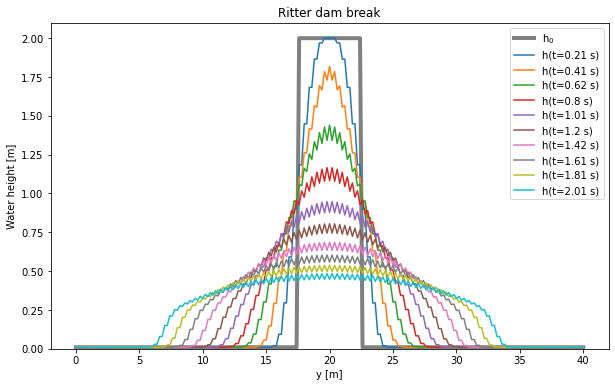

In [5]:
# Finite volume with Rusanov flux scheme
# start time
time   = 0
dtplot = 0.20
tplot  = dtplot
# initialisation
x   = np.linspace(xmin,xmax,nx)
y   = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y,indexing='ij')
h   = 0*X
h   = np.where(np.sqrt((Y-mu)**2)<= radius,2.,0.01)
hu  = 0*X
hv  = 0*X
# add ghost cells
X  = addGhostCells2D(X,xmin,xmax,ymin,ymax)
Y  = addGhostCells2D(Y,xmin,xmax,ymin,ymax)
h  = addGhostCells2D(h,0,0,0,0)
hu = addGhostCells2D(hu,0,0,0,0)
hv = addGhostCells2D(hv,0,0,0,0)
# initial plot
XM = X[int(nx/2),int(nx/2)]
print(int(nx/2),int(nx/2),XM)
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('y [m]')
plt.ylabel('Water height [m]')
plt.title('Ritter dam break')
#plt.contour(X[1:-1,1:-1],Y[1:-1,1:-1],h[1:-1,1:-1],levels=[0.5,0.8,1.5])
plt.plot(Y[1:-1,1:-1][X[1:-1,1:-1]==XM],
         h[1:-1,1:-1][X[1:-1,1:-1]==XM],linewidth=4,color='gray',label='h$_0$')
# solution
while (time < T):
    # set boundary conditions
    h  = bcNeumann2D(h)
    hu = bcNeumann2D(hu)
    hv = bcNeumann2D(hv)
    
    h = np.maximum(0.01,h)
    c = np.sqrt(g*h)
    u = hu/h #uu*h/h
    v = hv/h #vv*h/h
    
    maxeigenu = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    maxeigenv = np.max(np.maximum(np.abs(v-c),np.abs(v+c)))
    maxeigen  = max(maxeigenu,maxeigenv)
    dt = dtCourant(dx,dy,maxeigenu,maxeigenv,time,T,CFL)
    #print('dt: ',dx,dt,time,maxeigen)
    # advance time
    time  = time+dt
    
    Fhup = h[1:,:]*u[1:,:]
    Fhum = h[:-1,:]*u[:-1,:]
    Fhvp = h[:,1:]*v[:,1:]
    Fhvm = h[:,:-1]*v[:,:-1]
    
    Fhu2p = hu[1:,:]*u[1:,:] + 0.5*g*h[1:,:]**2
    Fhu2m = hu[:-1,:]*u[:-1,:] + 0.5*g*h[:-1,:]**2
    Fhuvp = h[:,1:]*u[:,1:]*v[:,1:]
    Fhuvm = h[:,:-1]*u[:,:-1]*v[:,:-1]
    
    Fhuv2p = h[1:,:]*u[1:,:]*v[1:,:]
    Fhuv2m = h[:-1,:]*u[:-1,:]*v[:-1,:]
    Fhv2p = hv[:,1:]*v[:,1:] + 0.5*g*h[:,1:]**2
    Fhv2m = hv[:,:-1]*v[:,:-1] + 0.5*g*h[:,:-1]**2
    
    # R = Lax-Friedrichs Flux
    Rhx  = (Fhup+Fhum)/2 - dx/dt/2*(h[1:,:]-h[:-1,:])
    Rhy  = (Fhvp+Fhvm)/2 - dy/dt/2*(h[:,1:]-h[:,:-1])
    
    Rhux  = (Fhu2p+Fhu2m)/2 - dx/dt/2*(hu[1:,:]-hu[:-1,:])
    Rhuy  = (Fhuvp+Fhuvm)/2 - dy/dt/2*(hu[:,1:]-hu[:,:-1])
    
    Rhvx  = (Fhuv2p+Fhuv2m)/2 - dx/dt/2*(hv[1:,:]-hv[:-1,:])
    Rhvy  = (Fhv2p+Fhv2m)/2 - dy/dt/2*(hv[:,1:]-hv[:,:-1])
    
    # update inner points
    h[1:-1,1:-1] = h[1:-1,1:-1] - dt/dx*(Rhx[1:,1:-1]-Rhx[:-1,1:-1]) \
                                - dt/dy*(Rhy[1:-1,1:]-Rhy[1:-1,:-1])
    hu[1:-1,1:-1] = hu[1:-1,1:-1] - dt/dx*(Rhux[1:,1:-1]-Rhux[:-1,1:-1]) \
                                - dt/dy*(Rhuy[1:-1,1:]-Rhuy[1:-1,:-1])
    hv[1:-1,1:-1] = hv[1:-1,1:-1] - dt/dx*(Rhvx[1:,1:-1]-Rhvx[:-1,1:-1]) \
                                - dt/dy*(Rhvy[1:-1,1:]-Rhvy[1:-1,:-1])
    if (time > tplot):
        #plt.contour(X,Y,h,levels=[0.5,0.8,1.5])
        plt.plot(Y[1:-1,1:-1][X[1:-1,1:-1]==XM],
                 h[1:-1,1:-1][X[1:-1,1:-1]==XM],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

----
## Two-sided Ritter dam break

$x$- and $y$-directions

100 100 19.8


/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819/2275871759.py:73: RuntimeWarning: overflow encountered in multiply
  Rhux = (Fhu2p+Fhu2m)/2 - dx/dt/2*(hu[1:,:]-hu[:-1,:])
/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819/2275871759.py:73: RuntimeWarning: overflow encountered in subtract
  Rhux = (Fhu2p+Fhu2m)/2 - dx/dt/2*(hu[1:,:]-hu[:-1,:])
/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819/2275871759.py:74: RuntimeWarning: overflow encountered in multiply
  Rhuy = (Fhuvp+Fhuvm)/2 - dy/dt/2*(hu[:,1:]-hu[:,:-1])
/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819/2275871759.py:76: RuntimeWarning: overflow encountered in multiply
  Rhvx = (Fhuv2p+Fhuv2m)/2 - dx/dt/2*(hv[1:,:]-hv[:-1,:])
/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819/2275871759.py:77: RuntimeWarning: overflow encountered in multiply
  Rhvy = (Fhv2p+Fhv2m)/2 - dy/dt/2*(hv[:,1:]-hv[:,:-1])
/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_1819

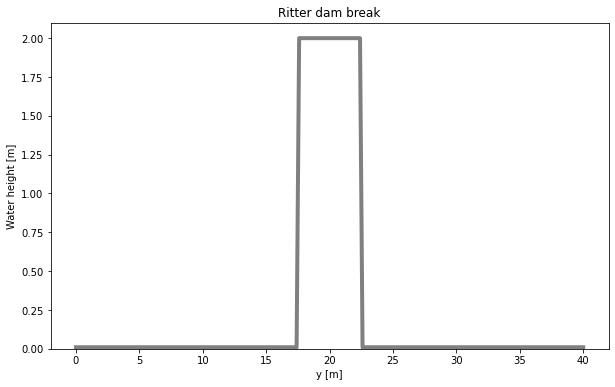

In [6]:
# Finite volume with Rusanov flux scheme
# start time
time   = 0
dtplot = 0.20
tplot  = dtplot
# initialisation
x   = np.linspace(xmin,xmax,nx)
y   = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y,indexing='ij')
h   = 0*X
#h   = np.where(np.sqrt((Y-mu)**2)<= radius,2.,0.01)
h   = np.where((np.sqrt((X-mu)**2)<= radius) & (np.sqrt((Y-mu)**2)<= radius),2.,0.01)
hu  = 0*X
hv  = 0*X
# add ghost cells
X  = addGhostCells2D(X,xmin,xmax,ymin,ymax)
Y  = addGhostCells2D(Y,xmin,xmax,ymin,ymax)
h  = addGhostCells2D(h,0,0,0,0)
hu = addGhostCells2D(hu,0,0,0,0)
hv = addGhostCells2D(hv,0,0,0,0)
# initial plot
XM = X[int(nx/2),int(nx/2)]
print(int(nx/2),int(nx/2),XM)
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('y [m]')
plt.ylabel('Water height [m]')
plt.title('Ritter dam break')
#plt.contour(X[1:-1,1:-1],Y[1:-1,1:-1],h[1:-1,1:-1],levels=[0.5,0.8,1.5])
plt.plot(Y[1:-1,1:-1][X[1:-1,1:-1]==XM],
         h[1:-1,1:-1][X[1:-1,1:-1]==XM],linewidth=4,color='gray',label='h$_0$')
# solution
while (time < T):
    # set boundary conditions
    h  = bcNeumann2D(h)
    hu = bcNeumann2D(hu)
    hv = bcNeumann2D(hv)
    
    h = np.maximum(0.1,h)
    c = np.sqrt(g*h)
    u = hu/h #uu*h/h
    v = hv/h #vv*h/h
    hu = np.where(hu < 0.1, 0, hu)
    hv = np.where(hv < 0.1, 0, hv)
    
    maxeigenu = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    maxeigenv = np.max(np.maximum(np.abs(v-c),np.abs(v+c)))
    maxeigen  = max(maxeigenu,maxeigenv)
    dt = dtCourant(dx,dy,maxeigenu,maxeigenv,time,T,CFL)
    #print('dt: ',dx,dt,time,maxeigen)
    # advance time
    time  = time+dt
    
    Fhup = hu[1:,:]
    Fhum = hu[:-1,:]
    Fhvp = hv[:,1:]
    Fhvm = hv[:,:-1]
    
    Fhu2p = hu[1:,:]*hu[1:,:]/h[1:,:] + 0.5*g*h[1:,:]**2
    Fhu2m = hu[:-1,:]*hu[:-1,:]/h[:-1,:] + 0.5*g*h[:-1,:]**2
    Fhuvp = hu[:,1:]*hv[:,1:]/h[:,1:]
    Fhuvm = hu[:,:-1]*hv[:,:-1]/h[:,:-1]
    
    Fhuv2p = hu[1:,:]*hv[1:,:]/h[1:,:]
    Fhuv2m = hu[:-1,:]*hv[:-1,:]/h[:-1,:]
    Fhv2p  = hv[:,1:]*hv[:,1:]/h[:,1:] + 0.5*g*h[:,1:]**2
    Fhv2m  = hv[:,:-1]*hv[:,:-1]/h[:,:-1] + 0.5*g*h[:,:-1]**2
    
    # R = Lax-Friedrichs Flux
    Rhx  = (Fhup+Fhum)/2 - dx/dt/2*(h[1:,:]-h[:-1,:])
    Rhy  = (Fhvp+Fhvm)/2 - dy/dt/2*(h[:,1:]-h[:,:-1])
    
    Rhux = (Fhu2p+Fhu2m)/2 - dx/dt/2*(hu[1:,:]-hu[:-1,:])
    Rhuy = (Fhuvp+Fhuvm)/2 - dy/dt/2*(hu[:,1:]-hu[:,:-1])
    
    Rhvx = (Fhuv2p+Fhuv2m)/2 - dx/dt/2*(hv[1:,:]-hv[:-1,:])
    Rhvy = (Fhv2p+Fhv2m)/2 - dy/dt/2*(hv[:,1:]-hv[:,:-1])
    
    # update inner points
    h[1:-1,1:-1]  = h[1:-1,1:-1] - dt/dx*(Rhx[1:,1:-1]-Rhx[:-1,1:-1]) \
                                 - dt/dy*(Rhy[1:-1,1:]-Rhy[1:-1,:-1])
    hu[1:-1,1:-1] = hu[1:-1,1:-1] - dt/dx*(Rhux[1:,1:-1]-Rhux[:-1,1:-1]) \
                                  - dt/dy*(Rhuy[1:-1,1:]-Rhuy[1:-1,:-1])
    hv[1:-1,1:-1] = hv[1:-1,1:-1] - dt/dx*(Rhvx[1:,1:-1]-Rhvx[:-1,1:-1]) \
                                  - dt/dy*(Rhvy[1:-1,1:]-Rhvy[1:-1,:-1])
    if (time > tplot):
        #plt.contour(X,Y,h,levels=[0.5,0.8,1.5])
        plt.plot(Y[1:-1,1:-1][X[1:-1,1:-1]==XM],
                 h[1:-1,1:-1][X[1:-1,1:-1]==XM],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

... done